In [1]:
import numpy as np
from astropy.io import fits

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.labelsize']= 20*1.1
mpl.rcParams['legend.fontsize']= 15*1.4
mpl.rcParams['xtick.major.size']= 16*1.4
mpl.rcParams['xtick.minor.size']= 8*1.4
mpl.rcParams['ytick.major.size']= 16*1.4
mpl.rcParams['ytick.minor.size']= 8*1.4
mpl.rcParams['xtick.labelsize']= 20
mpl.rcParams['ytick.labelsize']= 20
mpl.rcParams['mpl_toolkits.legacy_colorbar']=False

import model_shock as MS
import model_ionization as MI
import plot_functions as pfunc
import extinction as ex

<ipython-input-1-654eeb8397df>:15: MatplotlibDeprecationWarning: 
The mpl_toolkits.legacy_colorbar rcparam was deprecated in Matplotlib 3.4 and will be removed two minor releases later.
  mpl.rcParams['mpl_toolkits.legacy_colorbar']=False
/home/joseaher/Dropbox/work/prog/packages_astrocubelib/task/__init__.py:40: UserWarning: Trying to register the cmap 'b' which already exists.
  plt.register_cmap(cmap=mapb)



# Loading flux maps 


In [2]:
NII_flux_ext = fits.open('NII_flux_ext.fits')[0].data
OIII_flux_ext = fits.open('OIII_flux_ext.fits')[0].data
ha_flux_ext = fits.open('Ha_flux_ext.fits')[0].data
hb_flux_ext = fits.open('Hb_flux_ext.fits')[0].data
ha_ew = fits.open('Ha_ew.fits')[0].data

# image scale
sc = 1
# scale units
unitsc = 'pix'

# Masking the Starforming spaxels

In [3]:
###################
# Defining ratios #
###################

N2 = np.log10(np.copy(NII_flux_ext/ha_flux_ext))
OIII_hb = np.log10(np.copy(OIII_flux_ext/hb_flux_ext))
OIII_hbt = np.copy(OIII_flux_ext/hb_flux_ext)
#O3N2 = np.log10((10**OIII_hb)*(ha_flux/NII_flux))



#############
# BPT mask  #
#############

lim_kewley = np.copy(N2)
lim_kewley[N2<0.47] = 1.19 + 0.61/(N2[N2<0.47] - 0.47)
lim_kewley[N2>=0.47] = -9999

lim_kauff = np.copy(N2)
lim_kauff[N2<0.05] = 1.30 + 0.61/(N2[N2<0.05] - 0.05)
lim_kauff[N2>=0.05] = -9999

lim_stasi = np.copy(N2)
lim_stasi[N2<-0.20] = 0.96 + 0.29/(np.copy(N2[N2<-0.20]) + 0.20)
lim_stasi[N2>=-0.20] = -9999

bpt_mask = np.zeros((N2.shape[0],N2.shape[1]))
bpt_mask[OIII_hb>lim_kauff] =np.nan

# EW mask
EW_mask = np.zeros((N2.shape[0],N2.shape[1]))
EW_mask[ha_ew<6] =np.nan

bpt_mask = bpt_mask + EW_mask 


####################################################################
# WHAN mask (for spalexs with not OIII/Hbeta measures  only aplies #
####################################################################
whan_mask = np.zeros((N2.shape[0],N2.shape[1]))
whan_mask[(ha_ew>6)  & (N2>-0.4)  & np.isnan(OIII_hbt)] = np.nan


####################
# Diagnostic mask  #
####################

diag_mask = bpt_mask + whan_mask 

fits.writeto('mask_bpt.fits', bpt_mask, overwrite=True)
fits.writeto('mask_whan.fits', whan_mask, overwrite=True)
fits.writeto('mask_diag.fits', diag_mask, overwrite=True)



# WHAN Diagram


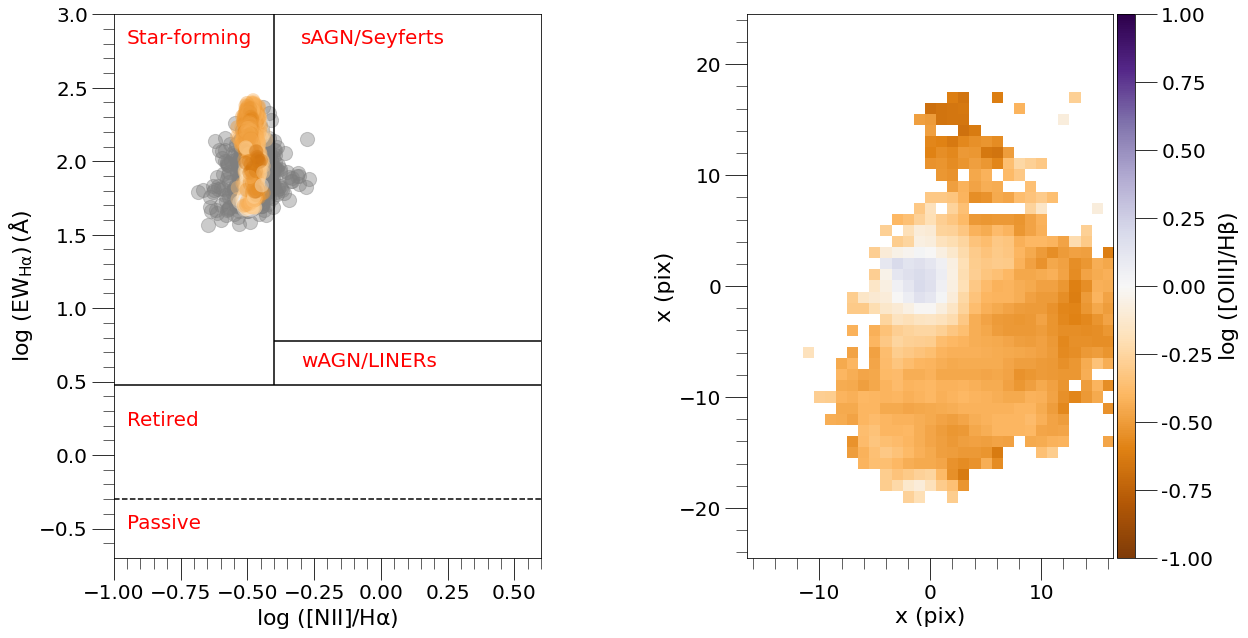

In [4]:
fig = plt.figure(figsize=(21, 10))

plt.subplots_adjust(wspace=0.1)
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_aspect(0.55)


############################################
# Plotting the data without OII/hbeta ratio

N2_t  = np.copy(N2)
ha_ew_t  = np.copy(ha_ew)

N2_t[~np.isnan(OIII_hbt)] = np.nan
ha_ew_t[~np.isnan(OIII_hbt)] = np.nan

xt = np.copy(N2_t.ravel())
yt = np.copy(np.log10(ha_ew_t.ravel()))

plt.scatter(xt, yt,  s=200, color='tab:grey', alpha=0.4)


############################################
# Plotting the data with OII/hbeta ratio

xt = np.copy(N2.ravel())
yt = np.copy(np.log10(ha_ew.ravel()))
ct = np.copy(OIII_hb.ravel())

vminp = -1
vmaxp = 1

plt.scatter(xt, yt, c=ct, s=200, edgecolor='none', alpha=0.4, 
            vmin=vminp, vmax=vmaxp, cmap='PuOr')

tNII_ha = np.copy(N2)
tha_ew = np.copy(np.log10(ha_ew))


#######################################
# Plotting classification lines of WHAN

plt.text(-0.95, 2.8, 'Star-forming', fontsize=20, color='r')
plt.text(-0.95, 0.2, 'Retired', fontsize=20, color='r')
plt.text(-0.95, -0.5, 'Passive', fontsize=20, color='r')

plt.text(-0.3, 0.6, 'wAGN/LINERs', fontsize=20, color='r')
plt.text(-0.3, 2.8, 'sAGN/Seyferts', fontsize=20, color='r')

plt.vlines(-0.4, np.log10(3), 3, linestyles='solid', colors='k')

if np.nanmin(N2_t) > -1:
    minlim_w = -1
else:
    minlim_w = np.nanmin(N2_t) - 0.1

plt.hlines(np.log10(6), -0.4, 0.6, linestyles='solid', colors='k')
plt.hlines(np.log10(3), minlim_w, 0.6, linestyles='solid', colors='k')
plt.hlines(np.log10(0.5), minlim_w, 0.6, linestyles='dashed', colors='k')


plt.xlabel('$\mathrm { log\,\,([NII]/H\\alpha)}$')
plt.ylabel('$\mathrm { log\,\,(EW_{H\\alpha})\,(\\AA)}$')
plt.xlim(minlim_w, 0.6)
plt.ylim(-0.7, 3.0)
plt.minorticks_on()

#########################
# Plotting OIII/Hbeta map

ax2 = fig.add_subplot(1, 2, 2)

# pfunc.bar([ha_flux_orig.shape[1] * 0.5, ha_flux_orig.shape[0] * 0.5], 0.1*sc_kpc,
#           5*sc_kpc*0.1, '5$^{\prime\prime}$', parr='2', larrow=5, nx=3, ny=1,
#           postxt=1.3, cbar='k-', ctex='k', linew=2, AX=ax2, bartexs=20)

# plt.plot(cirx+xcir,ciry+ycir,'k--',lw=2)


pfunc.figure(OIII_hb, [0, 0], [0, 0], [vminp, vmaxp, 0],
             'PuOr', sc,
             #flipaxes=[-1,1],
             cbaropt=3, cbar=['vertical', 1.0, 0.4, '%.2f'],
             cbarl='$\mathrm { log\,\,([OIII]/H\\beta)}$',
             figtitle='none', outima='none',
             #nameaxis=['$\Delta \\alpha$ (arcsec)', '$\Delta\delta$ (arcsec)'],
             nameaxis=['x ({})'.format(unitsc), 'x ({})'.format(unitsc)],
             AX=ax2)


##################
# Saving WHAN plot

plt.savefig('fig_diag_whan.png', bbox_inches='tight')


# Photoionizing Model

In [5]:
####################################
#  Plot grid Photoinozation Models #
#################################### 

cod = 'SB99' 

age = '8Myr'; sb  = 'cont'
#ne  = 'n350'; atm = 'L'; 
ne  = 'n10'; atm = 'L'

#age = '0Myr'; sb  = 'inst'
#ne  = 'n350'; atm = 'L';
#ne  = 'n10' ; atm = '';
#
#cod = 'Peg' 
#
#age = '4Myr'; sb  = 'cont'
#ne  = 'n350'; atm = 'L'
#ne  = 'n10' ; atm = ''
#
#age = '0Myr'; sb  = 'inst'
#ne  = 'n350'; atm = 'L'
#ne  = 'n10' ; atm = ''

ionphbeta = MI.gridphot('hbeta', cod, sb, age, ne, atm)
ionpOIII  = MI.gridphot('OIII', cod, sb, age, ne, atm)
ionpNII   = MI.gridphot('NII', cod, sb, age, ne, atm)
ionphalfa = MI.gridphot('halfa', cod, sb, age, ne, atm)
ionpSII   = MI.gridphot('SII', cod, sb, age, ne, atm)
ionpSII2  = MI.gridphot('SII2', cod, sb, age, ne, atm)

aZ = np.arange(0, ionphalfa.shape[0])
aQ = np.arange(0, ionphalfa.shape[1])


print ('Number of Z = {}'.format(len(aZ)), ' Z')
print ('Number of Q = {}'.format(len(aQ)), "km/s")

Number of Z = 5  Z
Number of Q = 7 km/s


# Shock Models

In [6]:
##############################
# plot the grid Shock Models #
###############################

#abu = 'R' #twice n=1
#abu = 'J' #Dopita n=1
#abu = 'P' # SMC
#abu = 'Q' # LMC
abu = 'M'  #solar abundace n=1
#abu = 'U'  #solar abundace n=0.1
#abu = 'V' #solar abundace n=10.
#abu = 'L' #solar abundace n=100.
#abu = 'S' #solar abundace n=1000.

vechbeta, gB, gvel = MS.gridshock('hbeta', abu, '_sp_lines.txt')
vecOIII,  gB, gvel = MS.gridshock('OIII', abu, '_sp_lines.txt')
vecNII,   gB, gvel = MS.gridshock('NII', abu, '_sp_lines.txt')
vecNII2,  gB, gvel = MS.gridshock('NII2', abu, '_sp_lines.txt')
vechalfa, gB, gvel = MS.gridshock('halfa', abu, '_sp_lines.txt')
vecSII,   gB, gvel = MS.gridshock('SII', abu, '_sp_lines.txt')
vecSII2,  gB, gvel = MS.gridshock('SII2', abu, '_sp_lines.txt')


#vechbeta, gB, gvel = MS.gridshock('hbeta', abu, '_s_lines.txt')
#vecOIII,  gB, gvel = MS.gridshock('OIII', abu, '_s_lines.txt')
#vecNII,   gB, gvel = MS.gridshock('NII', abu, '_s_lines.txt')
#vecNII2,  gB, gvel = MS.gridshock('NII2', abu, '_s_lines.txt')
#vechalfa, gB, gvel = MS.gridshock('halfa', abu, '_s_lines.txt')
#vecSII,   gB, gvel = MS.gridshock('SII', abu, '_s_lines.txt')
#vecSII2,  gB, gvel = MS.gridshock('SII2', abu, '_s_lines.txt')
#
#
#vechbeta   =  vechbeta[:,:4] 
#vecOIII    =   vecOIII[:,:4] 
#vecNII     =    vecNII[:,:4]  
#vecNII2    =   vecNII2[:,:4] 
#vechalfa   =  vechalfa[:,:4]
#vecSII     =    vecSII[:,:4]  
#vecSII2    =   vecSII2[:,:4] 

aV = np.arange(0, vechbeta.shape[1])
aB = np.arange(0, vechbeta.shape[0])

print ('Number of Vel = {}'.format(len(aV)), gvel, ' km/s')
print ('Number of B = {}'.format(len(aB)), gB, "microG")

Number of Vel = 9 [ 200.  300.  400.  500.  600.  700.  800.  900. 1000.]  km/s
Number of B = 8 ['0.0001', '0.5', '1.0', '2.0', '3.23', '4.0', '5.0', '10.0'] microG


# lines of Classification

In [7]:
x_i = -1.8

xl_K01 = np.linspace(x_i, 0.4699, 50)  #0.47
xl_K03 = np.linspace(x_i, 0.0499, 50)  #0.5
xl_S06 = np.linspace(x_i, -0.199, 50)  #-0.2 
xl_K06 = np.linspace(-0.2,0.5,50)

# Data from Cid Fernandes et al. 2010
aK01, bK01, cK01 = 1.19, 0.61, -0.47  # SF/ANG kewley 01
aK03, bK03, cK03 = 1.30, 0.61, -0.05  # SF/AGN kaufman 03
aS06, bS06, cS06 = 0.96, 0.29, 0.20  # SF/AGN
aK06, bK06 = 1.01, 0.48  # Seyferts/LINER

yK01 = aK01 + bK01 / (xl_K01 + cK01)  # SF/ANG
yK03 = aK03 + bK03 / (xl_K03 + cK03)  # SF/ANG
yS06 = aS06 + bS06 / (xl_S06 + cS06)  # SF/ANG
yK06 = aK06 * xl_K06 + bK06  # Seyferts/LINER

# BPT 

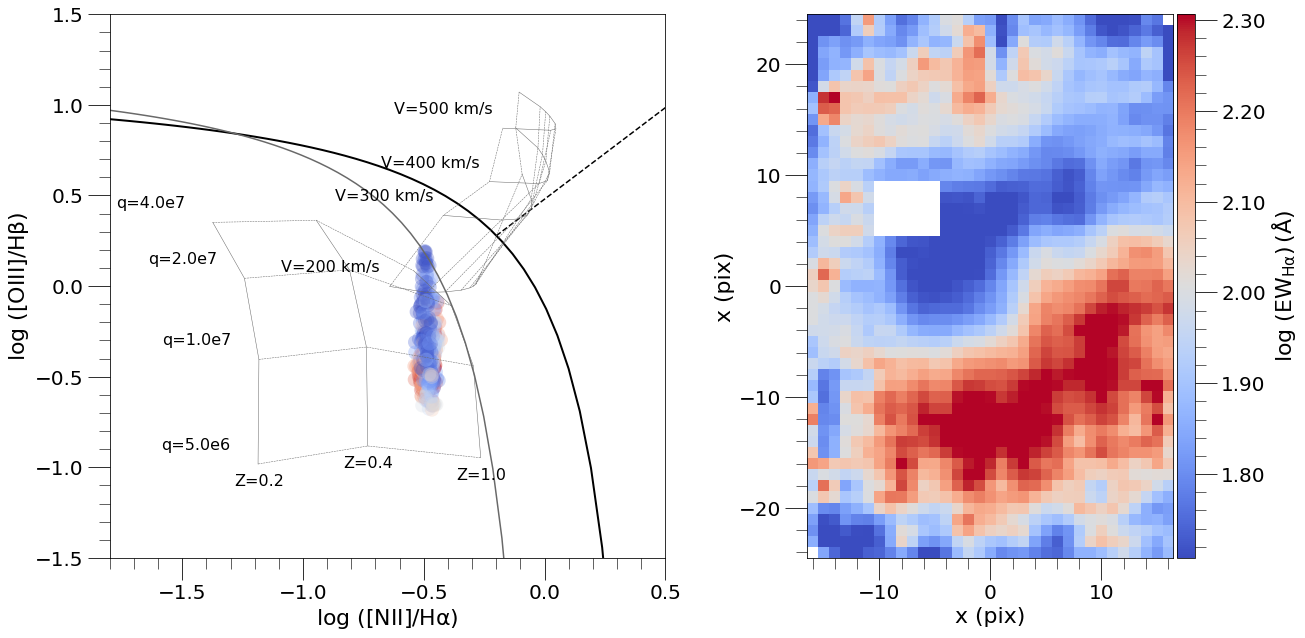

In [8]:
fig=plt.figure(figsize=(21,10))
plt.subplots_adjust(wspace=0.1)
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_aspect(0.75)


######################
# Plotting the Data

xt = np.copy(N2.ravel())
yt = np.copy(OIII_hb.ravel())
yc = np.copy(np.log10(ha_ew.ravel()))

vminp = np.percentile(yc[~np.isnan(yc)], 5)
vmaxp = np.percentile(yc[~np.isnan(yc)], 95)


plt.scatter(xt, yt, c=yc, s=200, edgecolor='none', alpha=0.3, vmin=vminp, 
             vmax=vmaxp,
            cmap='coolwarm')

###################################
# Plotting the classification lines
 

plt.plot(xl_K01, yK01, 'k-', lw=2.0, label='Kewley 01')
plt.plot(xl_K03, yK03, c='#696969', lw=1.5, label='Kauffmann 03')
#plt.plot(xl_S06, yS06, c='#696969', ls='--', lw=1.5, label='Stasinska 06')
plt.plot(xl_K06, yK06, 'k--', lw=1.5, label='Liners')

########################
# Plotting photo models

Zi = 1
Zf = 4
Qi = 3
Qf = 8

# run metalicity
for i in aZ[Zi:Zf]:
    x1 = np.log10(ionpNII[i, Qi:Qf]/(ionphalfa[i, Qi:Qf]))
    y1 = np.log10(ionpOIII[i, Qi:Qf])
    plt.plot(x1, y1, c='#696969', ls='-', lw = 0.5)
    plt.text(x1[-1] - 0.1, y1[-1] - 0.12, MI.txtZ99[i], fontsize=16)

# run Q parameter
for i in aQ[Qi:Qf]:
    x1 = np.log10(ionpNII[Zi:Zf, i]/(ionphalfa[Zi:Zf, i]))
    y1 = np.log10(ionpOIII[Zi:Zf, i])
    plt.plot(x1, y1, c='#696969', ls='--', lw = 0.5)
    plt.text(x1[0]-0.4, y1[0]+0.08, MI.txtQ[i], fontsize=16)
   

#########################
# Plotting shock models
 
Bi=0
Bf=18
Vi=0
Vf=4
    
# Run B    
for i in aB[Bi:Bf]:
    x1 = np.log10(vecNII[i, Vi:Vf]/(vechalfa[i, Vi:Vf]))
    y1 = np.log10(vecOIII[i, Vi:Vf])
    plt.plot(x1, y1, c='#696969', ls='--', lw = 0.5)
    
# Run velocity 
for i in aV[Vi:Vf]:
    x1 = np.log10(vecNII[Bi:Bf, i]/(vechalfa[Bi:Bf, i]))
    y1 = np.log10(vecOIII[Bi:Bf, i])
    plt.plot(x1, y1, c='#696969', ls='-', lw = 0.5)     
    plt.text(x1[0]-0.45, y1[0]+0.08, 'V={:.0f} km/s'.format(gvel[i]), fontsize=16)

plt.ylim(-1.5, 1.5)
plt.xlim(-1.8,0.5)
plt.minorticks_on()
plt.xlabel('$\mathrm { log\,\,([NII]/H\\alpha)}$')#, size='x-large')
plt.ylabel('$\mathrm { log\,\,([OIII]/H\\beta)}$')#, size='x-large')

#####################
#  Plotting EW Map  

ax2 = fig.add_subplot(1, 2, 2)

pfunc.figure(np.log10(ha_ew), cent=[0, 0], delta=[0, 0], limt=[vminp, vmaxp, 0],
             cmap='coolwarm', scale=sc,
             
             cbaropt=3, cbar=['vertical', 1.0, 0.4, '%.2f'],
             cbarl='$\mathrm { log\,\,(EW_{H\\alpha})\,(\\AA)}$',
             figtitle='none', outima='none',
             #nameaxis=['$\Delta \\alpha$ (arcsec)', '$\Delta\delta$ (arcsec)'],
             #flipaxes=[-1,1],
             nameaxis=['x ({})'.format(unitsc), 'x ({})'.format(unitsc)], AX=ax2)

plt.minorticks_on()

#################
# Saving the plot
plt.savefig('fig_diag_bpt.png', bbox_inches='tight')